# Preprocessing of the Twitter Data

**Import libraries**:

In [1]:
import sys
import os
import logging
import pickle
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import re
from sklearn.ensemble import IsolationForest
from collections import defaultdict
import pdb
import gc
from functools import partial
import ast
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

**Setup logging:**

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

**Set up path**

In [3]:
path = "/home/piotr/projects/twitter"
path_preprocessed = os.path.join(path, 'data/clean')
sys.path.append(os.path.join(path, "src"))
ndays = 84

## Lemmatization:

The preprocessing and lemmatization is performed through the `Preprocessor` class, which performs the following task:
- ensures integrity of each record, drops it if any problems occur - for example, unexpected data types key fields containing text, user IDs or Tweet date
- drops Tweets marked as having a different language than Polish or undefined
- removes URLs, numbers, emojis and user mentions from each Tweet's text
- replaces hashtags included in Tweets with words
- marks the retweets in the dataset
- tokenizes the text, performs POS tagging and lemmatization on each of the texts using the preprocessing Pipeline from the `stanza` library. Two separate fields are kept - `tokenized` for tokenized data after the preprocessing steps mentioned above and `lemmatized` for fully lemmatized data
- no stopword removal is performed at this point
- computes the proportion of Polish tokens in the data using the spell checker from the `pyenchant` library

First, I set up the parameters for lemmatization - file directories, chunk size for the preprocessor, etc.

In [4]:
keep_cols = ['full_text', 'created_at', 'id_str', 'user-id_str'] #columns to be kept
path_record = os.path.join(path, "data/clean/record.json") #path to store records
chunk_size = 10000 #chunk size for CSV reader
pos_batch_size = 1000 #batch size for POS tagger

In [5]:
from twitter_tools.preprocessing import Preprocessor
def preprocess(path_raw, path_preprocessed, preprocessor, keep_cols, path_record = None, 
               chunk_size = 10000, pos_batch_size = 1000):
    """
    Takes preprocessor as argument to avoid re-instantiation.
    """
    #record:
    if path_record and os.path.isfile(path_record):
        record = json.load(open(path_record, "r"))
        record = defaultdict(lambda: 0, record)
    else:
        record = defaultdict(lambda: 0)
    names = pd.read_csv(path_raw, dtype = str, nrows = 1, index_col = 0).columns #get column name
    for df in pd.read_csv(path_raw, iterator = True, dtype = str, 
                           skiprows = record[path_raw] + 1,
                           chunksize = chunk_size, index_col = 0, 
                           names = names):
        res = preprocessor.preprocess(df)
        
        if res is not None:
            
            if os.path.isfile(path_preprocessed):
                res.to_csv(path_preprocessed, mode = "a", header = False) #append if exists
            else:
                res.to_csv(path_preprocessed, mode = "w") #else write to new

            record[path_raw] += chunk_size

            if path_record:
                json.dump(dict(record), open(path_record, "w"))

#### Government Tweets - February-May

In [12]:
if not os.listdir(path_preprocessed):
    path_raw = '/media/piotr/SAMSUNG/data/gov'
    preprocessor = Preprocessor(keep_cols = keep_cols, pos_batch_size = pos_batch_size) #init
    files = [f for f in os.listdir(path_raw) if 'csv' in f]
    for file in tqdm(files):
        preprocess(os.path.join(path_raw, file), os.path.join(path_preprocessed, file), preprocessor, 
                   keep_cols, path_record = path_record, chunk_size = 10000, pos_batch_size = 1000)
        gc.collect()

#### Opposition Tweets - February-May

In [13]:
if not os.listdir(path_preprocessed):
    path_raw = '/media/piotr/SAMSUNG/data/opp'
    preprocessor = Preprocessor(keep_cols = keep_cols, pos_batch_size = pos_batch_size) #init
    files = [f for f in os.listdir(path_raw) if 'csv' in f]
    for file in tqdm(files):
        preprocess(os.path.join(path_raw, file), os.path.join(path_preprocessed, file), preprocessor, 
                   keep_cols, path_record = path_record, chunk_size = 10000, pos_batch_size = 1000)
        gc.collect()

## Cleaning

#### Load the data:

In [7]:
from twitter_tools.utils import read_files
data = pd.DataFrame()
for df in tqdm(read_files(path_preprocessed, ndays = ndays, prefixes = ['opp', 'gov'], dtype = str)):
    data = data.append(df)
data.loc[:,('polish')] = data.loc[:,('polish')].astype(float)

- **Removing Tweets in a different language** - Some of the users scraped were using other languages than Polish, rendering any form of NLP analysis of their content difficult. To remove them, I analyzed the average proportion of non-Polish tokens in the lemmatized version of their tweets:

In [47]:
path_drop = os.path.join(path, 'results/cleaning/users_drop_ids.json')
from twitter_tools.utils import read_files
if not os.path.isfile(path_drop):
    #Get ids of "nonpolish" users, i.e. those with average number of Polish tokens below 0.3
    polishness = data.groupby(['user-id_str']).mean()['polish']
    drop_ids = polishness[polishness < 0.3].index.tolist()
    print(f"Number of non-Polish users {len(drop_ids)}")
    print("Example tweets:")
    tweets_nonpolish = data[data['user-id_str'].apply(lambda x: x in drop_ids)]
    np.random.seed = 1234
    for i in np.random.choice(np.arange(0, tweets_nonpolish.shape[0]), 50):
        print("-" + tweets_nonpolish.tokenized.iloc[i])
else:
    drop_ids = json.load(open(path_drop, 'r'))

Number of non-Polish users 53
Example tweets:
-fotografía photography nature naturaleza life dreams
-odilon redon la sphere globe
-photography nikon nikonglobal nikonphotography nikonnofilter
-emailextractor webscraping targetedemail
-vladimir putin odhaľuje západ ovládajú satanskí pedofili
-just posted трамп выпускает джина из бутылки on reddit
-china lied people died make chinapay chinazi virus
-by marcin gorski
-presne podľa plánu kalergi zbaviť sa inteligentejšej rasy krížením rás vytvori ť negroidniho podčloveka bez práv nároku len poslušného otroka
-cdnpoli
-kwsk
-oh
-aj tu sa ukázalo potvrdilo že demokracia liberálneko kapitalizmu je vedúca do záhuby ako to už preukázalo minulosti čo vyústilo do vojen svetových kríz kde zahyuli miliónov civilistov mene bankových zbrojných korporácií
-aliennation
-mjesečev put utočište
-kraków kazimierz
-idd jkucharski covidbc covid bcpoli cdnpoli
-daniel volkov
-rusi zachraňujú zadky amíkom
-just posted как не признанных мая отмечают on reddit
-

- **Removing bots/users with suspicious levels of activity** - drop users with extremely high number of daily Tweets (excluding Retweet activity). 'Extremely active' is understood as users with higher activity than the 99th quantile of the average daily number of tweets.

In [8]:
#drop retweets
drop = np.logical_not(data['retweet'].apply(lambda x: ast.literal_eval(x)))
data = data.loc[drop, :]
counts = data.groupby(['user-id_str', 'day'])['lemmatized'].count().reset_index()
counts_avg = counts.groupby('user-id_str').agg({'lemmatized':'mean'}).sort_values('lemmatized', ascending = False)
counts_avg

,lemmatized
user-id_str,
1223528125952417792,286.300000
28522629,168.171429
818748422866006016,153.051282
2188644971,152.431373
899193463371182080,143.833333
...,...
71028646,1.000000
1224765147757056002,1.000000
1224467950922620928,1.000000


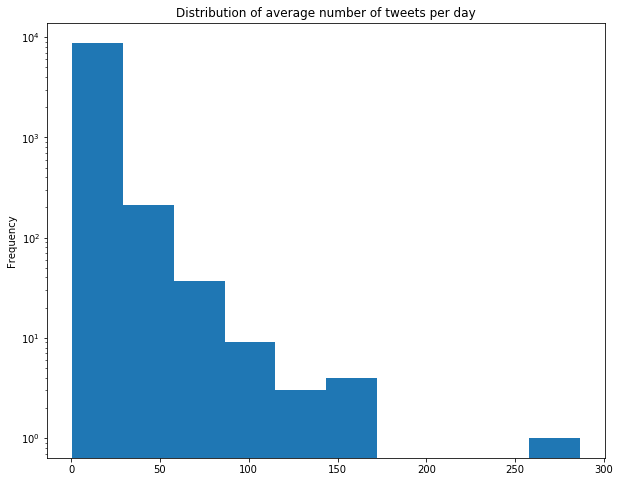

In [9]:
counts_avg.plot.hist(figsize = (10, 8), legend = None, title = 'Distribution of average number of tweets per day')
plt.yscale('log')
plt.show()

I added the user tho tweeted 286 times per day to the list of profiles to be removed. The profile was later removed, so it seems like this could have been a bot activity.

In [24]:
counts_avg

,lemmatized
user-id_str,
1223528125952417792,286.300000
28522629,168.171429
818748422866006016,153.051282
2188644971,152.431373
899193463371182080,143.833333
...,...
71028646,1.000000
1224765147757056002,1.000000
1224467950922620928,1.000000


In [25]:
path_drop = os.path.join(path, 'results/cleaning/users_drop_ids.json')
lim = counts_avg.quantile(0.99999)[0]
print(f'99.999th quantile of original tweet numbers {lim}')
high_activity = counts_avg[counts_avg['lemmatized'] > lim].reset_index()['user-id_str'].tolist()
print(f'Number of problematic ids {len(high_activity)}')
if not os.path.isfile(path_drop):
    drop_ids = list(set(users_nonpolish + high_activity))
    json.dump(drop_ids, open(path_drop, 'w'))
else:
    drop_ids = json.load(open(path_drop, 'r'))

99.999th quantile of original tweet numbers 275.5798321429294
Number of problematic ids 1


Also look at any local irregularities, i.e. users exceeding the average number in each given day:

In [26]:
counts[np.logical_not(counts['user-id_str'].isin(drop_ids))].sort_values('lemmatized', ascending = False)

,user-id_str,day,lemmatized
109068,2840954536,2020-05-15,365
109500,28522629,2020-05-02,353
123897,3233772889,2020-05-01,344
174797,4839322828,2020-05-15,343
1063,1004342026547154944,2020-05-15,340
...,...,...,...
66569,1353653154,2020-03-24,1
156662,422173654,2020-02-22,1
156663,422173654,2020-02-24,1
156665,422173654,2020-02-27,1


## Outlier removal
- next, using the Sentence Embeddings method (based on fasttext vectors with 300 dimensions), I identify potential outliers in the data using the IsolationForrest algorithm and remove them

In [10]:
path_embeddings = '/home/piotr/nlp/cc.pl.300.vec'
from twitter_models.embeddings import OutlierDetector
def filter_fun(df, cols, drop_ids, drop_duplicates = True):
    df = df[np.logical_not(df['user-id_str'].isin(drop_ids))] #drop IDs that are to be excluded
    df = df[df.polish.astype(float) > 0.5] #don't include non-Polish
    if drop_duplicates:
        df.drop_duplicates(inplace = True)
    df = df[cols]
    return df
ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'id_str'], drop_ids = drop_ids)

In [17]:
path_outliers = os.path.join(path, 'results/cleaning/outliers.json')
if os.path.isfile(path_outliers):
    outliers = json.load(open(path_outliers, 'r')) #load the outlier dict
else:
    from twitter_tools.utils import batch
    data = pd.DataFrame()
    for df in tqdm(read_files(path_preprocessed, 84, prefixes = ["opp", "gov"], dtype = str, 
                              filter_fun = ff)):
        data = data.append(df)
    data.drop_duplicates(inplace = True) #keep only unique tweets
    splitter = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 1234) #get a train-test split
    detector = OutlierDetector(path_embeddings, IsolationForest(n_jobs = 3), a = 0.001) #init detector
    tr, ts = next(splitter.split(data, data['day'] + data['source'])) #split - stratify by date and source
    data = data.lemmatized #keep just the lemmatized text column
    print(f'Train size {tr.shape}')
    detector.fit(data.iloc[tr].astype(str))
    pickle.dump(detector, open(os.path.join(path, 'results/cleaning/outlier_detector.p'), 'wb')) #save model
    print(f'Finished fitting. Predicting outliers')
    preds = [] #predict
    for i, text in tqdm(enumerate(batch(data, 500000))):
        preds.extend(detector.predict(text.astype(str)))
    outliers = dict(filter(lambda x: x[1] == -1, zip(data.tolist(), preds)))
    outliers = list(outliers.keys())
    
    #now load the data again without dropping the duplicates
    #and get a list of all tweet ids tagged as duplicates
    data = pd.DataFrame()
    ff = partial(filter_fun, cols = ['lemmatized', 'id_str'], drop_ids = drop_ids, drop_duplicates = False)
    for df in tqdm(read_files(path_preprocessed, 84, prefixes = ["opp", "gov"], dtype = str, 
                          filter_fun = ff)):
        data = data.append(df)
    data['outlier'] = data.lemmatized.isin(outliers)
    oulier_ids = data.loc[data.outlier,('id_str')].tolist()
    json.dump(outlier_ids, open(path_outliers, 'w'))

## Final step
Get ids of all tweets that should be removed based on the previous analysis + all with below 0.5 words in Polish

In [32]:
drop_users = json.load(open(os.path.join(path, 'results/cleaning/users_drop_ids.json'), 'r'))
outliers = json.load(open(os.path.join(path, 'results/cleaning/outliers.json'), 'r'))
def get_ids(df, drop_users: list, drop_tweets: list):
    drop = df['user-id_str'].isin(drop_users) #drop users that are to be excluded
    drop |= df['id_str'].isin(drop_tweets) #drop tweets that are to be excluded
    drop |= df.polish.astype(float) < 0.5 #drop tweets with less than 50% Polish
    ids = df.loc[drop, ('id_str')].tolist() #get ids
    return ids

In [37]:
path_tmp = os.path.join(path, 'results/cleaning/DROP_IDS.json')
if not os.path.isfile(path_tmp):
    ids_drop = []
    for df in tqdm(read_files(path_preprocessed, 84, prefixes = ["opp", "gov"], dtype = str)):
        ids_drop.extend(get_ids(df, drop_users = drop_users, drop_tweets = outliers))
    json.dump(ids_drop, open(path_tmp, 'w'))